# VQE on primitives

New primitive-based minimum eigensolvers can be found at `qiskit.algorithms.minimum_eigensolvers`. 

The previous implementations can still be found at `qiskit.algorithms.minimum_eigen_solvers`. These are now pending depreciation.

There are now two VQE classes:

* `VQE`: this is the "standard" VQE class and is based around an `Estimator` primitive (merged into `main`). PR: https://github.com/Qiskit/qiskit-terra/pull/8702 
* `SamplingVQE`: this is a specialized implementation for VQE extensions, such as when using CVaR objective function. This class is also subclassed by `QAOA` (close to being merged): https://github.com/Qiskit/qiskit-terra/pull/8669 

Let's look at a couple of examples of `VQE` in action. The operator below is the Hamiltonian operator for a $H_2$ molecule with an interatomic distance of 0.735A. The expected minimum eigenvalue is -1.857.

In [1]:
from qiskit.quantum_info.operators import SparsePauliOp

H2_op = SparsePauliOp(
    ["II", "IZ", "ZI", "ZZ", "XX"],
    coeffs=[
        -1.052373245772859,
        0.39793742484318045,
        -0.39793742484318045,
        -0.01128010425623538,
        0.18093119978423156,
    ],
)

aux_op1 = SparsePauliOp(["ZZ"], coeffs=[2.0])
aux_op2 = SparsePauliOp(["XX"], coeffs=[-2.0])


First, let's Define a callback function to plot the energy eigenvalue against the evaluation count.

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

counts = []
values = []

def plot_energy(eval_count, parameters, mean, metadata):
    counts.append(eval_count)
    values.append(mean)
    clear_output(wait=True)
    plt.plot(counts, values)
    plt.xlabel("Evaluation count")
    plt.ylabel("Energy")
    plt.title("Energy convergence")
    plt.show()

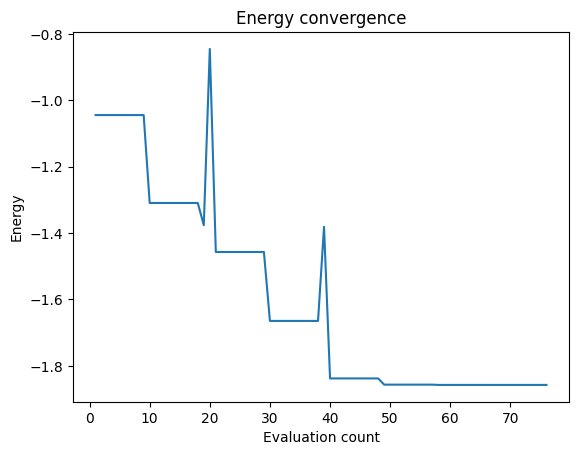

{   'aux_operators_evaluated': [   (-1.999999993187942, {}),
                                   (0.44348488032082867, {}),
                                   (0.0, {})],
    'cost_function_evals': 76,
    'eigenvalue': -1.8572750274142158,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): 2.261715279203688,
                              ParameterVectorElement(θ[6]): -1.780336037033357,
                              ParameterVectorElement(θ[4]): -4.148738282081337,
                              ParameterVectorElement(θ[3]): -3.7292625974461826,
                              ParameterVectorElement(θ[2]): -4.038964996561136,
                              ParameterVectorElement(θ[5]): -5.711428683908725,
                              ParameterVectorElement(θ[0]): 5.075160250087955,
                              ParameterVectorElement(θ[1]): -0.4114608746649981},
    'optimal_point': array([ 5.07516025, -0.41146087, -4.038965  , -3.7292626 , -4.14873828,
       -5.71142868, -1.780

In [3]:
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Estimator
from qiskit.algorithms.minimum_eigensolvers import VQE, VQEResult
from qiskit.algorithms.optimizers import SLSQP

# Reset plotting arrays.
counts.clear()
values.clear()

# Define the central primitive.
estimator = Estimator()

# Define our ansatz 
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
slsqp = SLSQP()

# Instantiate VQE. Note that all arguments after the optimizer must be specified by keyword.
vqe = VQE(estimator, ansatz, slsqp, callback=plot_energy)

# Compute the minimum eigenvalue. Not the primary operator is the H2_op. The auxillary operators are just variants for illustration.
# Note that None values are no longer supported. Zero values will be interpreted as a zero operator.
result = vqe.compute_minimum_eigenvalue(H2_op, [aux_op1, aux_op2, 0])
print(result)

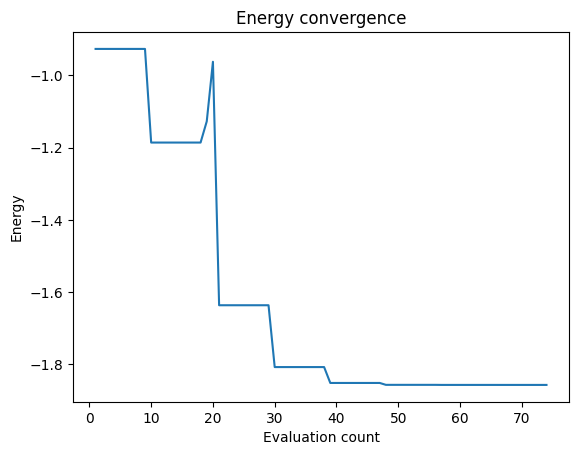

{   'aux_operators_evaluated': {   'aux_op1': (-1.999999980032821, {}),
                                   'aux_op2': (0.4435461378601737, {})},
    'cost_function_evals': 74,
    'eigenvalue': -1.8572750217841485,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): -2.0958840527531755,
                              ParameterVectorElement(θ[6]): 2.097769938764322,
                              ParameterVectorElement(θ[4]): -2.2704979148520215,
                              ParameterVectorElement(θ[3]): 4.512415277354272,
                              ParameterVectorElement(θ[2]): -5.3118677651393105,
                              ParameterVectorElement(θ[5]): 4.821902196866234,
                              ParameterVectorElement(θ[0]): 4.0029646228041695,
                              ParameterVectorElement(θ[1]): 0.7532240732097758},
    'optimal_point': array([ 4.00296462,  0.75322407, -5.31186777,  4.51241528, -2.27049791,
        4.8219022 ,  2.09776994, -2.09588405]),
   

In [4]:
# Reset plotting arrays.
counts.clear()
values.clear()

result = vqe.compute_minimum_eigenvalue(H2_op, {"aux_op1": aux_op1, "aux_op2": aux_op2})
print(result)

Specifying the shots in the primitive `options` enables one to recover the `variance` and `shots` from metadata. This information can also be obtained via the callback.

In [5]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np

counts = []
values = []
std_dev = []

def plot_energy_error(eval_count, parameters, mean, metadata):
    counts.append(eval_count)
    values.append(mean)
    variance = metadata.get("variance", 0.0)
    shots = metadata.get("shots", 0.0)
    std_dev.append(np.sqrt(variance / shots) if shots > 0 else 0.0)
    clear_output(wait=True)
    plt.errorbar(counts, values, std_dev)
    plt.xlabel("Evaluation count")
    plt.ylabel("Energy")
    plt.title("Energy convergence")
    plt.show()

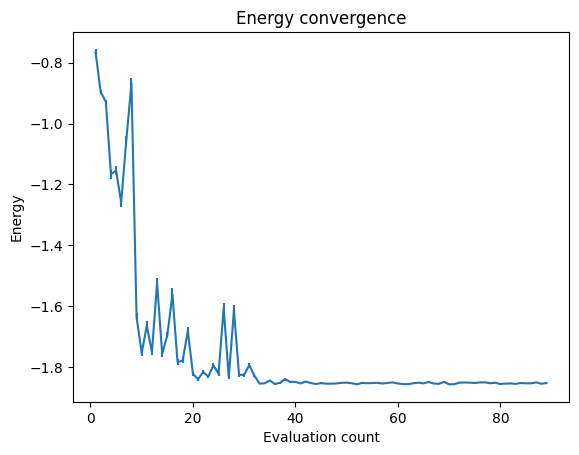

{   'aux_operators_evaluated': [   (   -1.9761671326903179,
                                       {   'shots': 1024,
                                           'variance': 3.8928042689898636}),
                                   (   0.2633342838717973,
                                       {   'shots': 1024,
                                           'variance': 3.8928042689898636})],
    'cost_function_evals': 89,
    'eigenvalue': -1.8529542559971324,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): 5.164573039425615,
                              ParameterVectorElement(θ[6]): 0.7505139963512656,
                              ParameterVectorElement(θ[4]): -4.660127156291442,
                              ParameterVectorElement(θ[3]): -0.5855190840047136,
                              ParameterVectorElement(θ[2]): 7.3384853958659235,
                              ParameterVectorElement(θ[5]): 4.157811122683297,
                              ParameterVectorElement(θ[0]): 0

In [6]:
counts.clear()
values.clear()

from qiskit.algorithms.optimizers import COBYLA

cobyla = COBYLA(maxiter=1000)

estimator = Estimator(options={"shots": 1024})

vqe = VQE(estimator, ansatz, cobyla, callback=plot_energy_error)
result = vqe.compute_minimum_eigenvalue(H2_op, [aux_op1, aux_op2])
print(result)

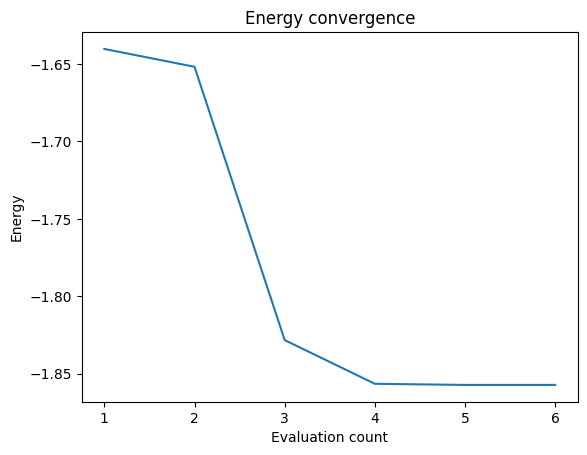

{   'aux_operators_evaluated': [   (3.4494705163051096, {}),
                                   (-0.9286375110213847, {})],
    'cost_function_evals': 6,
    'eigenvalue': -1.8572750220427694,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): -2.0538601026438768,
                              ParameterVectorElement(θ[6]): -1.1329287289114331,
                              ParameterVectorElement(θ[4]): -4.355303888576914,
                              ParameterVectorElement(θ[3]): 3.763122171479945,
                              ParameterVectorElement(θ[2]): -2.3090650639588897,
                              ParameterVectorElement(θ[5]): 4.535163374370298,
                              ParameterVectorElement(θ[0]): -2.7135845038125037,
                              ParameterVectorElement(θ[1]): 4.6980539839738835},
    'optimal_point': array([-2.7135845 ,  4.69805398, -2.30906506,  3.76312217, -4.35530389,
        4.53516337, -1.13292873, -2.0538601 ]),
    'optimal_value': -1

In [7]:
counts.clear()
values.clear()

from qiskit.algorithms.gradients import FiniteDiffEstimatorGradient

estimator = Estimator()

gradient = FiniteDiffEstimatorGradient(estimator, epsilon=0.001)

vqe = VQE(estimator, ansatz, slsqp, gradient=gradient, callback=plot_energy)
result = vqe.compute_minimum_eigenvalue(H2_op, [H2_op ** 2, H2_op / 2])
print(result)

In [8]:
counts.clear()
values.clear()

from qiskit.algorithms.gradients import ParamShiftEstimatorGradient
from qiskit.algorithms.optimizers import GradientDescent

estimator = Estimator()

gradient = FiniteDiffEstimatorGradient(estimator, epsilon=0.001)

vqe = VQE(estimator,
          ansatz,
          GradientDescent(maxiter=200, learning_rate=0.1),
          gradient=ParamShiftEstimatorGradient(estimator),
)

result = vqe.compute_minimum_eigenvalue(H2_op, [H2_op ** 2, H2_op / 2])
print(result)

{   'aux_operators_evaluated': [   (3.4494705378132404, {}),
                                   (-0.9286375151011882, {})],
    'cost_function_evals': 0,
    'eigenvalue': -1.8572750302023764,
    'optimal_parameters': {   ParameterVectorElement(θ[7]): -2.136938912379914,
                              ParameterVectorElement(θ[6]): 1.059107224541399,
                              ParameterVectorElement(θ[4]): -5.746076562835886,
                              ParameterVectorElement(θ[3]): -4.5380553790203875,
                              ParameterVectorElement(θ[2]): 3.970371260560466,
                              ParameterVectorElement(θ[5]): -0.772394674123938,
                              ParameterVectorElement(θ[0]): -1.7497204362773706,
                              ParameterVectorElement(θ[1]): -6.201539259301886},
    'optimal_point': array([-1.74972044, -6.20153926,  3.97037126, -4.53805538, -5.74607656,
       -0.77239467,  1.05910722, -2.13693891]),
    'optimal_value': -1.8

Let's look at the `SamplingVQE` implementation. This implementation is built around a `Sampler` primitive. This implementation is optimized for diagonal Hamiltonians. The reason for the separate `Sampler` based implementation is that certain extensions to VQE generalize the standard expectation value. Therefore we require more detailed information about the sampled measurements in order to generalize the mean using the `aggregator` argument.

In [9]:
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.algorithms.optimizers import SLSQP

# Reset plotting arrays.
counts.clear()
values.clear()

# Define the central primitive.
sampler = Sampler()

# Instantiate SamplingVQE. Note that all arguments after the optimizer must be specified by keyword.
sampling_vqe = SamplingVQE(sampler, ansatz, slsqp, callback=plot_energy)

result = sampling_vqe.compute_minimum_eigenvalue(H2_op)

ValueError: The observable must be diagonal.

The H2 operator is not diagonal, hence an error was raised. Let's define a suitable diagonal Hamiltonian. Setting `aggregration` to a float value means that this will interpreted as an $\alpha$ parameter with a CVaR expectation.

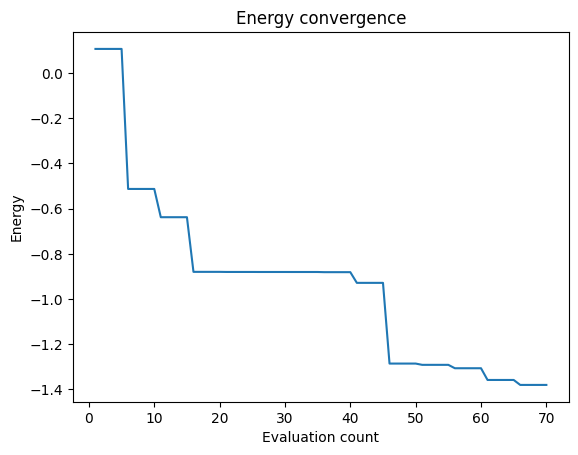

In [10]:
# Reset plotting arrays.
counts.clear()
values.clear()

diag_op = SparsePauliOp(["ZZ", "IZ", "II"], coeffs=[1, -0.5, 0.12])

sampler = Sampler()
from qiskit.circuit.library import RealAmplitudes

sampling_vqe = SamplingVQE(
            sampler,
            RealAmplitudes(2, reps=1),
            SLSQP(),
            aggregation=0.1,
            callback=plot_energy,
        )

sampling_vqe.compute_minimum_eigenvalue(operator=diag_op)